# Meteorološki podatki 

Najprej potrebujemo pridobiti meteorološke podatke na lokaciji stavbe.
Le ta stoji v Ljubljani, zato so GK koordinate sledeče: Y = 462645 m, X = 102486 m, pridobljeni podatki pa sledeči:

 - projektna temperatura okolice  $\theta_{e, ref}$: **-13°C**
 - povprečna letna temperatura okolice $\theta_{e, ann}$: **9.9°C**
 - povprečna mesečna dnevna energija sončnega obsevanja $G_{sol,i,d}$: **1121 kWh/m$^{2}$**
 - povprečna dnevna temperatura okolice $\theta_{e, d}$: Izračunana v naslednjih korakih.

In [1]:
thetaeref = -13 #°C
thetaeann = 9.9 #°C
gsolid = 1121 #kWh/m2

Uvozimo potrebne module

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Uvozimo podatke za tipično leto.
Podatki so v CSV datoteki s sledečimi vrsticami:

'Mesec', 'Dan', 'Ura', 'Temperatura', 'RelativnaVlaznost', 'GlobalnoSevanje', 'HitrostVetra', 'SmerVetra'

Uporabimo le prve štiri, 

In [3]:
import zModel

In [41]:
razredi = list(map(lambda x: ( x, x+2 ) , list(range(-18,20,4))))

Prikažemo lahko količine temperatur po razredih.

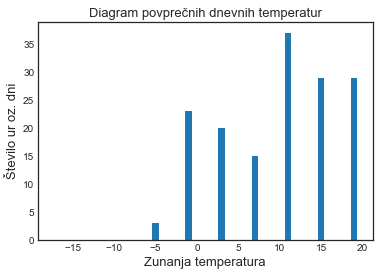

In [42]:
def displayTemperatureByTime():
    # Get the data
    data = zModel.temperaturesByTime(razredi,'meteorological_year_ljubljana.csv')
    x = list(map(lambda x: x[0], data))
    y = list(map(lambda x: x[1], data))
    # Create bars
    plt.bar(x, y)
    # Add axis titles
    plt.xlabel('Zunanja temperatura', fontsize='13', horizontalalignment='center')
    plt.ylabel('Število ur oz. dni', fontsize='13', horizontalalignment='center')
    plt.title('Diagram povprečnih dnevnih temperatur', fontsize='13')
    # Add design
    plt.style.use('seaborn-white')
    # Show graphic
    plt.show()
displayTemperatureByTime()

# Notranja projektna temperatura

Določiti moramo notranjo projektno temperaturo. Za stanovanje je $\theta_{i, ref}$: **20°C**
XXX

In [6]:
thetairef = 20 #°C

# Izračun potrebne toplotne moči toplotne črpalke

Sedaj, ko smo določili vse robne temperaturne pogoje, lahko začnemo z izračunom toplotnih moči. Če želimo določiti moč toplotne črpalke $\dot{Q}_{hp}$ moramo najprej določiti še toplotno moč potrebno za ogrevanje stavbe $\dot{Q}_{h}$, toplotno moč za pripravo STV $\dot{Q}_{stv}$ in moč drugih odjemov $\dot{Q}_{dod}$

Skupno moč tako določimo s sledečo enačbo, v kateri nastopi še korekcijski faktor akumulacije toplote:

$$\dot{Q}_{hp} =  \dot{Q}_{hp} * f_{h} + \dot{Q}_{stv} + \dot{Q}_{dod}$$

Preden določimo toplotno moč, moramo določiti vse člene zgornje enačbe.

## Korekcijski faktor
Izbran je korekcijski faktor $f_{h} = 0.93$ za opečnato stanovanjsko hišo iz 1970.



In [7]:
fh = 0.93

## Toplotna moč za ogrevanje stavbe
Toplotno moč za ogrevanje stavbe $\dot{Q}_{h}$ se izračuna kot seštevek transmisijskih, ventilacijskih in dodatnih toplotnih izgub:

$$\dot{Q}_{h} = \dot{Q}_{t} + \dot{Q}_{v}+ \dot{Q}_{h,dod}$$


### Transmisijske toplotne izgube in ventilacijske izgube
Transmisijske toplotne izgube so bile določene s pomočjo programa Gradbena fizika URSA 4, v okviru predmeta Raba Energije. V naslednji sliki so prikazani izračunani koeficijenti transmisijskih in ventilacijskih toplotnih izgub $H_{t}$ in $H_{v}$.

<img src="ursa_izracun.png">

Določimo lahko torej:

$$ H_{t} = 257.6 W/K $$
$$ H_{v} = 107.7 W/K $$
$$ H = 365.3 W/K $$

In [8]:
h = 365.3/1000 #kW/K

Za določitev moči uporabimo enačbo:

$$\dot{Q}_{h} = H*(\theta_{i,ref} - \theta_{e,ref})$$

In [9]:
dQh = h * (thetairef - thetaeref)
print(f'Toplotna moč za ogrevanje stavbe je: {round(dQh)}kW')

Toplotna moč za ogrevanje stavbe je: 12kW


## Toplotna moč za pripravo sanitarne tople vode
### Dnevna potrebna energija
Sedaj moramo določiti še toplotno moč potrebno za pripravo STV. Predpostavimo da uporabljamo zalogovnik STV. V enačbi za določitev dnevne energije STV $Q_{stv}$ upoštevamo število uporabnikov $N$, poprečno uporabo STV na osebo $q$ in temperaturno razliko med zahtevano temperaturo STV $\theta_{dp,ref}$ in temperaturo sveže dobavljene vode $\theta_{cw}$:

$$ Q_{stv} = 0.00116 *N*q*(\theta_{dp,ref}-\theta_{cw})$$

Ker se pri izračunu gre za stanovansjko poslopje je izbran $q = 60 L/ (oseba*dan)$

In [10]:
q = 25 # L/oseba*dan

Izbrati moramo še željeno temperaturo STV $\theta_{dp,ref}$, standardna je $60°C$, zato bomo to izbrali tudi mi, ter temperaturo hladne vode v omrežju $\theta_{cw}$, ki je izbrana na $12°C$

V poslopju sta dve gospodinjstvi, skupno pa trenutno v poslopju stanuje 5 oseb. Torej: $N=5$.

In [11]:
thetacw = 12 #°C
thetadpref = 60 #°C
N = 5 #število oseb

Sedaj lahko izračunamo dnevno energijo za STV.

In [12]:
Qstv = 0.00116 * N * q * (thetadpref-thetacw)
print(f'Dnevna energija potrebna za ogrevanje STV je: {round(Qstv,0)}kWh')

Dnevna energija potrebna za ogrevanje STV je: 7.0kWh


Iz energije lahko moč določimo s sledečo enačbo:
$$\dot{Q}_{stv} = \frac{Q_{stv}}{t_{stv}}*f_{stv}$$

Za $f_{stv}$ uporabimo vrednost 1.21
Čas ogrevanja STV pa izberemo da je 4 ure. $t_{stv}=4ure$

In [13]:
fstv = 1.21
tstv = 2 #ure
dQstv = Qstv/tstv*fstv
print(f'Potrebna moč za zagotavljanje nemotene oskrbe STV je {round(dQstv,0)} kW')

Potrebna moč za zagotavljanje nemotene oskrbe STV je 4.0 kW


### Velikost hranilnika STV
Najprej moramo določiti volumen vode, ki zadošča pokrivanju dnevne porabe STV, nato pa je potrebno upoštevati še dnevne toplotne izgube hranilnika STV.

Enačba ki popisuje potrebno velikost volumna vode je sledeča. V njej nastopa, poleg do sedaj že definiranih spremenljivk še dnevne toplotne izgube hranilnika $Q_{1,s}$ in učinkovitost volumna hranilnika, ki v povprečju znaša $\eta_{s} = 0.8$.

Sicer je $Q_{1,s}$ odvisen od velikosti volumna vendar, ker bomo zalogovnik izbrali iz kataloga, in ker drugi člen predstavlja veliko manjši del kot prvi, se lahko izračunu z diferencialno enačbo izognemo, ter minimalni volumen določimo le s prvim členom, drugega pa nato upoštevamo pri določitvi minimalnega volumna. 
$$V_{dp,ref}=\frac{860*(\dot{Q}_{stv}*t_{stv})}{(\theta_{dp,ref}-\theta_{cw})*\eta_{s}}+\frac{Q_{1,s}}{0.00116*(\theta_{dp,ref}-\theta_{cw})}$$

In [14]:
etas = 0.8
Vdpref1 = (860*dQstv*tstv)/((thetadpref-thetacw)*etas)
print(f'Preliminarni volumen hranilnika znaša {round(Vdpref1,0)}L')

Preliminarni volumen hranilnika znaša 189.0L


Sedaj lahko iz preliminarnega volumna določimo še toplotne izgube in jih upoštevamo v celotnem izračunu.

<img src="izgubevstv.png">

Pri preliminarnem volumnu 450L znaša dnevna izgubljena energija približno 3.2 kWh

In [15]:
Q1s = 1.5 #kWh/dan
Vdpref2 = Vdpref1 + Q1s/(0.00116 * (thetadpref-thetacw))
print(f'Volumen hranilnika znaša {round(Vdpref2,0)}L')

Volumen hranilnika znaša 216.0L


### Izbor hranilnika iz kataloga
V KRONOTERM katalogu je za izbrano ADAPT 0416 enoto na voljo 200 litrski hranilnik. Pri gospodarni rabi STV bo le-ta zadostoval. $V_{s}=200L$.

<img src="notranjaenota.png">

In [16]:
Vs = 200 #L

Na podlagi izbranega volumna lahko določimo dejansko potrebno moč toplotne črpalke po naslednji enačbi:

$$\dot{Q}_{stv,0set}=\frac{V_{s}*0.00116*(\theta_{set}-\theta_{cw})}{t_{stw}}$$

In [17]:
dQstv0set = (Vs*0.00116*(thetadpref-thetacw))/tstv
print(f'Prava moč toplotne črpalke za dobavljanje STV znaša {round(dQstv0set,0)}kW')

Prava moč toplotne črpalke za dobavljanje STV znaša 6.0kW


## Skupna toplotna moč
Sedaj lahko izračunamo še skupno toplotno moč, katero mora dosegati toplotna črpalka.

-E---ENAČBA



In [18]:
dQhp = dQh * fh + dQstv0set
print(f'Skupna toplotna moč znaša {round(dQhp,0)}kW')

Skupna toplotna moč znaša 17.0kW


# Raba energije za delovanje toplotne črpalke

## Toplotna energija za ogrevanje in pripravo STV
### Toplotna energija za ogrevanje stavbe

Potrebno toplotno energijo bomo določili po naslednji enačbi.
Ker je površina južno obrnjenih oken majhna in ker je osenčenost v ogrevalni sezoni velika, se dobitke zaradi sončnega sevanja $Q_{sol,d}$ zanemari.

Uporabimo enačbo:
$$Q_{h,d}=\dot{Q}_{h}*\frac{\theta_{i,ref}-\theta_{e,d}}{\theta_{i,ref}-\theta_{e,ref}}*24-Q_{hg,d}$$

Notranje toplotne dobitke $Q_{hg,d}$, ki predstavljajo oddajo naprav in ljudi pa določimo po povprečni vrednosti $4 W/m^{2}$

In [19]:
Qhgd = 4*181/1000
print(f'Skupni notranji toplotni dobitki znašajo {round(Qhgd,0)}kW')

Skupni notranji toplotni dobitki znašajo 1.0kW


Sedaj lahko določimo povprečne zunanje temperature na podlagi prej nastavljenih razredov.

In [43]:
thetaed = zModel.temperaturesByTime(razredi, returnShape='temperature')
thetaed = np.array(thetaed)
thetaed

array([-17., -13.,  -9.,  -5.,  -1.,   3.,   7.,  11.,  15.,  19.])

S pomočjo teh temperatur lahko določimo toplotne izgube v posameznih razredih.

In [44]:
Qhd = dQh*(thetairef-thetaed)/(thetairef-thetaeref)*24-Qhgd
Qhd

array([323.6624, 288.5936, 253.5248, 218.456 , 183.3872, 148.3184,
       113.2496,  78.1808,  43.112 ,   8.0432])

Če sedaj te izgube pomnožimo s številom dni (oziroma ur, odvisno od metode) določimo potrebno toplotno energijo za vsak razred posebej.

In [46]:
thetaedtime = np.array(zModel.temperaturesByTime(razredi,returnShape='time'))
Qhd*thetaedtime

array([   0.    ,    0.    ,    0.    ,  655.368 , 4217.9056, 2966.368 ,
       1698.744 , 2892.6896, 1250.248 ,  233.2528])

#### Celoletna toplotna energija
Nazadnje še seštejemo toplotne energije, da dobimo celoletno toplotno energijo za ogrevanje stavbe.

In [47]:
np.sum(Qhd*thetaedtime)

13914.576000000001

### Toplotna energija za pripravo STV
Potrebno toplotno energijo za pripravo STV se določi na osnovi že določene toplotne moči, z naslednjo enačbo:
$$Q_{stv,d}=\dot{Q}_{stv,0set}*t_{stv}$$

In [25]:
Qstvd=dQstv0set*tstv
print(f'Skupna dnevna raba energije za pripravo STV znaša {round(Qstvd,0)}kWh')

Skupna dnevna raba energije za pripravo STV znaša 11.0kWh


## Temperatura izstopajoče ogrevane vode

&&&&&&&&&&&&&&&&&&&&&&&& Manjka

## Čas delovanja toplotne črpalke


In [26]:
dQhp = 11


In [27]:
tonhpd=Qhd/dQhp+Qstvd/dQhp
tonhpd

array([30.43621818, 27.24814545, 24.06007273, 20.872     , 17.68392727,
       14.49585455, 11.30778182,  8.11970909,  4.93163636,  1.74356364])